In [52]:
# Importing libraries
import glob
import h5py
import mne
import numpy as np
import os
import scipy.io as sio
from matplotlib  import pyplot as plt
import pyntbci

In [53]:
# root directory for extracted data
root_data = r"C:\Users\s1081686\Desktop\RA_Project\Scripts\pynt_codes\SN_pilot_data\derivatives\pilot"

# You can use either of the two types of data for your analysis

# loading: OVERT data
os.chdir(root_data)
tmp_overt = np.load("pilot_cvep_overt_mgold_61_6521_40T.npz")
X = tmp_overt["X"]
y = tmp_overt["y"]
V = tmp_overt["V"].T
fs = tmp_overt["fs"]
fr = 60

#loading: COVERT data
# os.chdir(root_data)
# tmp_covert = np.load("pilot_cvep_covert_mgold_61_6521_40T.npz")
# X = tmp_covert["X"]
# y = tmp_covert["y"]
# V = tmp_covert["V"].T
# fs = tmp_covert["fs"]
# fr = 60

# For our experiment, we used only two classes. Hence, the flashing sequence matrix is limited to the first two codes in V.
V_needed = V[0:2,:]
V = V_needed

print("X", X.shape, "(trials x channels x samples)")  # EEG
print("y", y.shape, "(trials)")  # labels
print("V", V.shape, "(classes, samples)")  # codes
print("fs", fs, "Hz")  # sampling frequency
print("fr", fr, "Hz")  # presentation rate

# Extract data dimensions
n_trials, n_channels, n_samples = X.shape
n_classes = V.shape[0]

# Read cap file
path = r"C:\Users\s1081686\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyntbci\capfiles" 
capfile = os.path.join(path, "biosemi32.loc")
with open(capfile, "r") as fid:
    channels = []
    for line in fid.readlines():
        channels.append(line.split("\t")[-1].strip())
print("Channels:", ", ".join(channels))

X (40, 32, 1008) (trials x channels x samples)
y (40,) (trials)
V (2, 504) (classes, samples)
fs 240 Hz
fr 60 Hz
Channels: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, O1, Oz, O2, PO4, P4, P8, CP6, CP2, C4, T8, FC6, FC2, F4, F8, AF4, Fp2, Fz, Cz


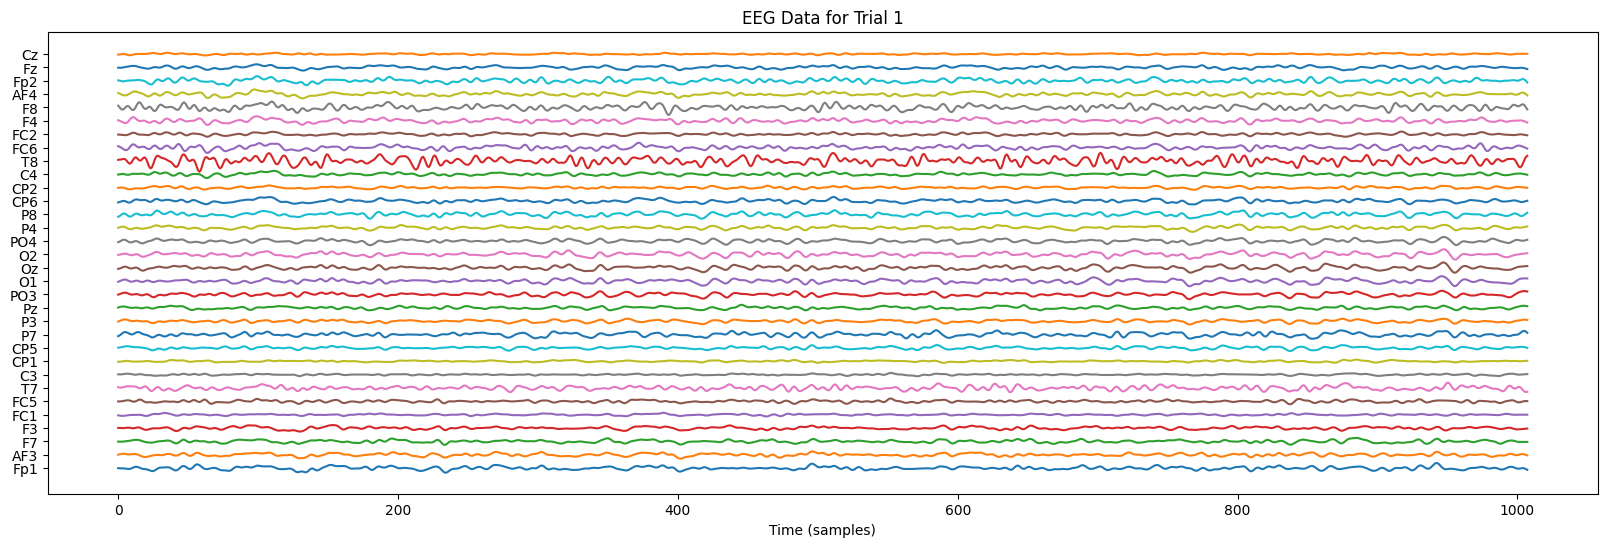

In [54]:
# Visualize EEG data
trial_idx = 0 # the trial to visualize

fig, ax = plt.subplots(figsize=(20, 6))
for i in range(len((X[trial_idx]))):
    ax.plot(X[trial_idx,i,:] + 40e-6*i)
    
    
ax.set_yticks([i*40e-6 for i in range(len(channels))])   
ax.set_yticklabels(channels)

ax.set_xlabel("Time (samples)")
ax.set_title(f"EEG Data for Trial {trial_idx + 1}")
plt.show()

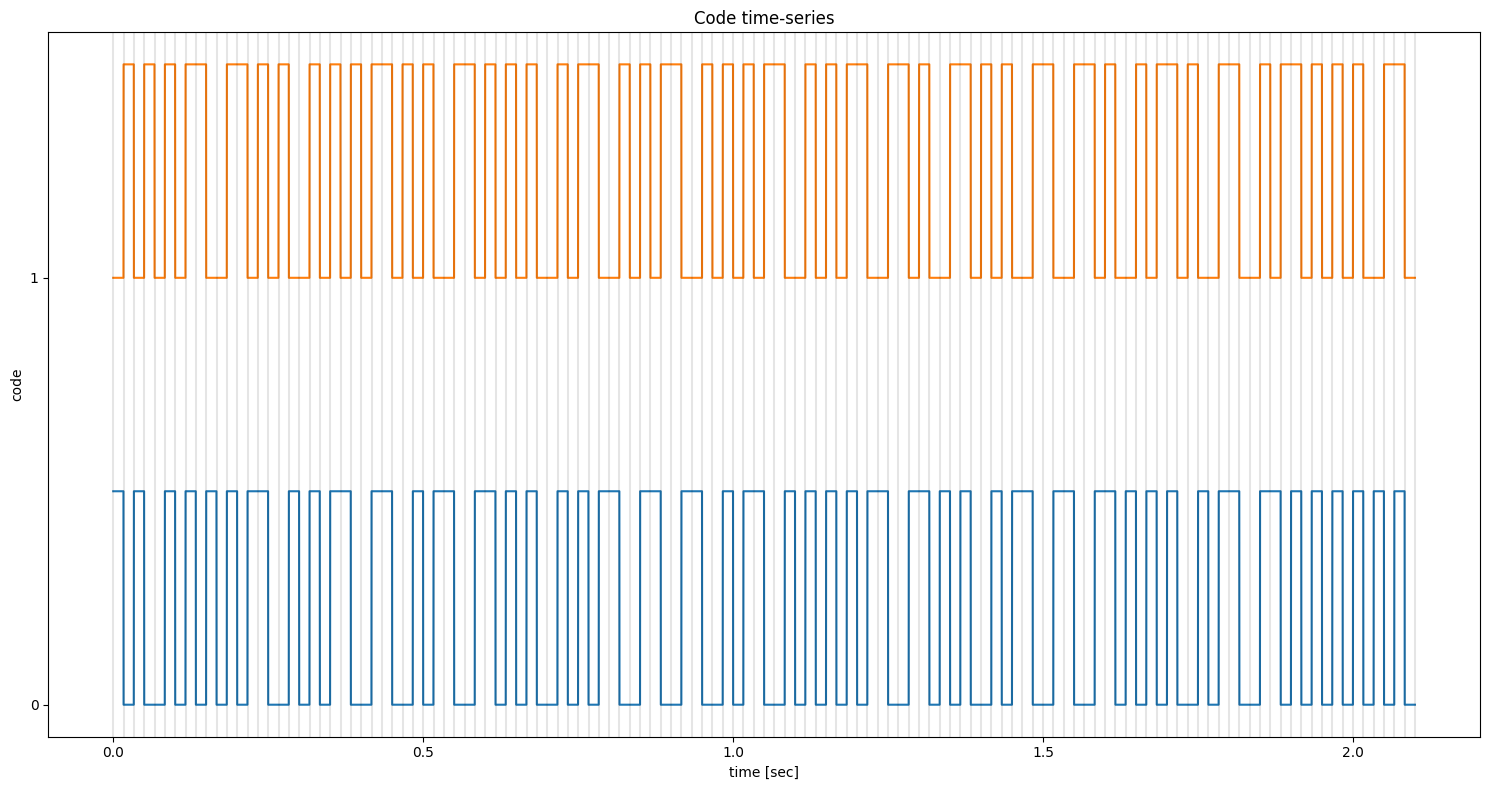

In [55]:
# Plotting codes
Vup = V.repeat(20, axis=1)  # upsample to better visualize the sharp edges
Vup = V.repeat(20, axis=1)  # upsample to better visualize the sharp edges
plt.figure(figsize=(15, 8))
plt.plot(np.arange(Vup.shape[1]) / (20 * fs), 2 * np.arange(n_classes) + Vup.T)
for i in range(1 + int(V.shape[1] / (fs / fr))):
    plt.axvline(i / fr, c="k", alpha=0.1)
plt.yticks(2*np.arange(n_classes), np.arange(n_classes))
plt.xlabel("time [sec]")
plt.ylabel("code")
plt.title("Code time-series")
plt.tight_layout()

In [56]:
# Create event matrix
E, events = pyntbci.utilities.event_matrix(V, event="duration", onset_event=True)
print("E:", E.shape, "(classes x events x samples)")
print("Events:", ", ".join([str(event) for event in events]))

E: (2, 3, 504) (classes x events x samples)
Events: 4, 8, onset


M: shape: (2, 216, 504) (classes x transient_size*events x samples)


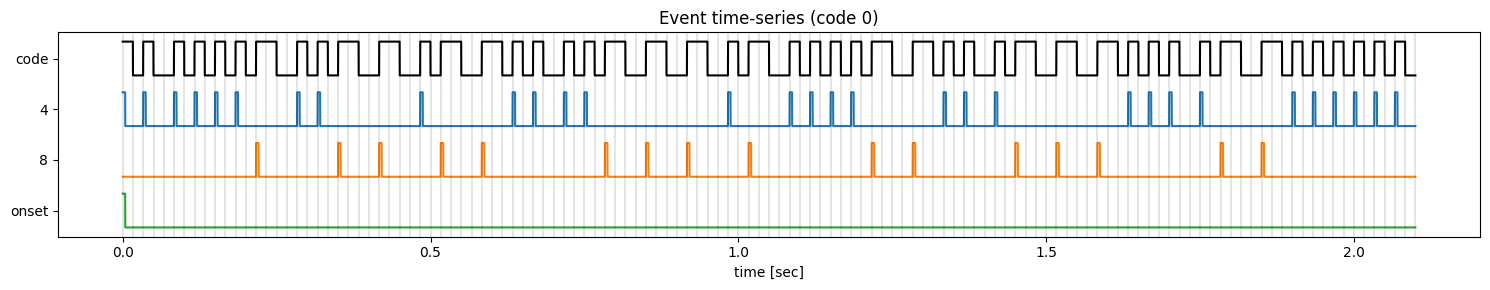

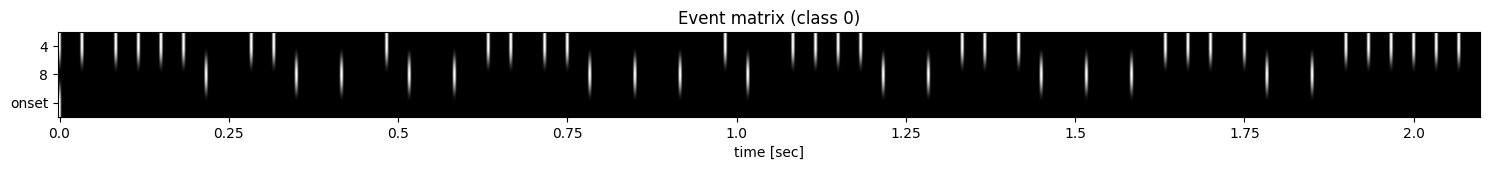

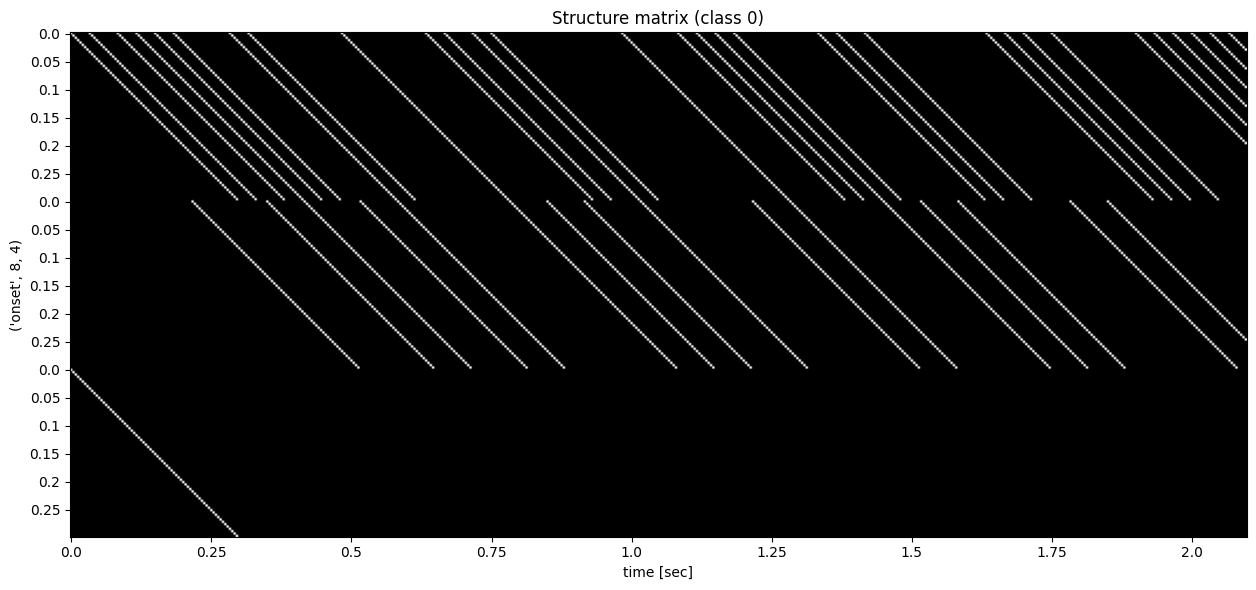

In [57]:
# Visualize event time-series
i_class = 0  # the class to visualize
Vu = V.repeat(20, axis=1)  # upsample to better visualize the sharp edges
Eu = E.repeat(20, axis=2)  # upsample to better visualize the sharp edges
plt.figure(figsize=(15, 3))
plt.plot(np.arange(0, Vu.shape[1]) / (20*fs), Vu[i_class, :], "k")
for i_event in range(E.shape[1]):
    plt.plot(np.arange(0, Eu.shape[2]) / (20*fs), -1.5 * (1 + i_event) + Eu[i_class, i_event, :])
for i in range(1 + int(V.shape[1] / (fs / fr))):
    plt.axvline(i / fr, c="k", alpha=0.1)
plt.yticks(-1.5 * np.arange(0, 1 + E.shape[1]) + 0.5, ("code",) + events)
plt.xlabel("time [sec]")
plt.ylabel("")
plt.title(f"Event time-series (code {i_class})")
plt.tight_layout()

# Visualize event matrix
i_class = 0
plt.figure(figsize=(15, 3))
plt.imshow(E[i_class, :, :], cmap="gray")
plt.gca().set_aspect(10)
plt.xticks(np.arange(0, E.shape[2], 60), np.arange(0, E.shape[2], 60) / fs)
plt.yticks(np.arange(E.shape[1]), events)
plt.xlabel("time [sec]")
plt.title(f"Event matrix (class {i_class})")
plt.tight_layout()

# Create structure matrix
transient_size = int(0.3 * fs)  # 300 ms responses
M = pyntbci.utilities.structure_matrix(E, transient_size)
print("M: shape:", M.shape, "(classes x transient_size*events x samples)")

# Plot structure matrix
i_class = 0  # the class to visualize
plt.figure(figsize=(15, 6))
plt.imshow(M[i_class, :, :], cmap="gray")
plt.xticks(np.arange(0, M.shape[2], 60), np.arange(0, M.shape[2], 60) / fs)
plt.yticks(np.arange(0, E.shape[1] * transient_size, 12), np.tile(np.arange(0, transient_size, 12) / fs, E.shape[1]))
plt.xlabel("time [sec]")
plt.ylabel(events[::-1])
plt.title(f"Structure matrix (class {i_class})")
plt.tight_layout()


w:  (32, 1) (channels)
r:  (216, 1) (transient_size*events)


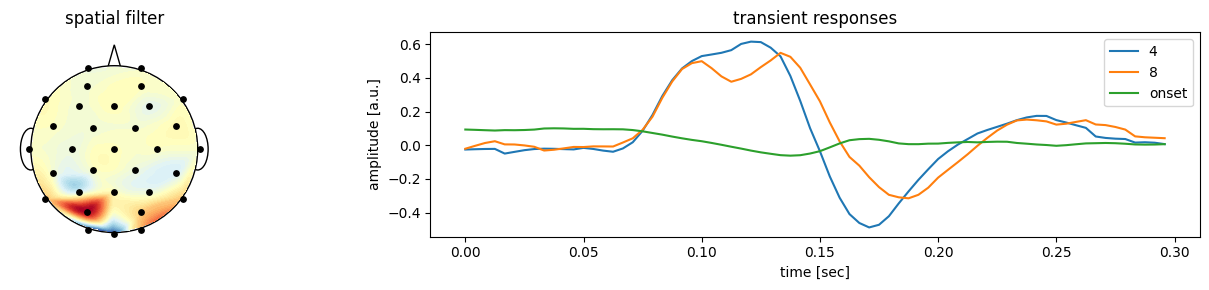

In [58]:
# Perform CCA decomposition with duration event
transient_size = 0.3  # 300 ms responses
rcca = pyntbci.classifiers.rCCA(codes=V, fs=fs, event="duration", transient_size=transient_size, onset_event=True)
rcca.fit(X, y)
print("w: ", rcca.w_.shape, "(channels)")
print("r: ", rcca.r_.shape, "(transient_size*events)")

# Plot CCA filters
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
pyntbci.plotting.topoplot(rcca.w_, capfile, ax=ax[0])
ax[0].set_title("spatial filter")
tmp = np.reshape(rcca.r_, (len(rcca.events_), -1))
for i in range(len(rcca.events_)):
    ax[1].plot(np.arange(int(transient_size * fs)) / fs, tmp[i, :])
ax[1].legend(rcca.events_)
ax[1].set_xlabel("time [sec]")
ax[1].set_ylabel("amplitude [a.u.]")
ax[1].set_title("transient responses")
fig.tight_layout()

(40,)
Accuracy: avg=1.00 with std=0.00
ITR: avg=51.3 with std=0.00


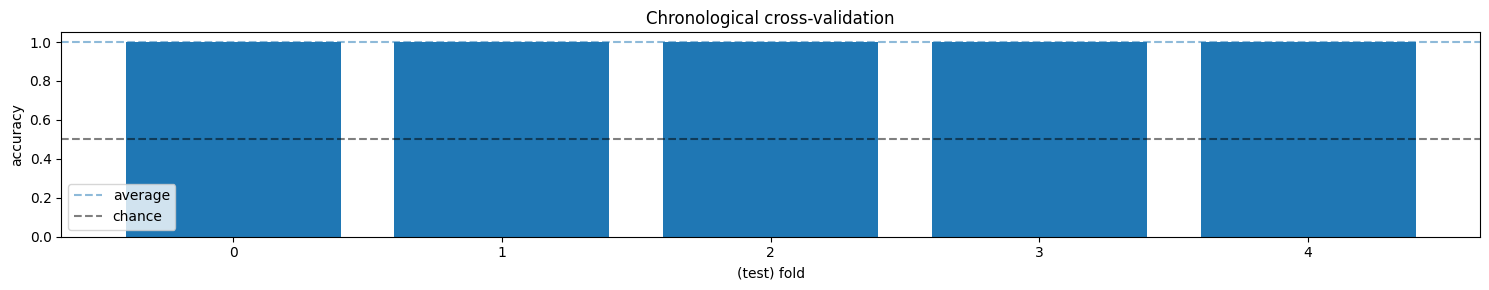

In [59]:
# Cross-validation
trialtime = 10.5  # limit trials to a certain duration in seconds
intertrialtime = 0  # ITI in seconds for computing ITR
n_samples = int(trialtime * fs)
if X.shape[0]==40:
    n_folds = 5
else:
    n_folds = 3



# Chronological cross-validation
folds = np.repeat(np.arange(n_folds), int(n_trials / n_folds))
print(folds.shape)

# Loop folds
accuracy = np.zeros(n_folds)
for i_fold in range(n_folds):

    # Split data to train and test set
    X_trn, y_trn = X[folds != i_fold, :, :n_samples], y[folds != i_fold]
    X_tst, y_tst = X[folds == i_fold, :, :n_samples], y[folds == i_fold]

    # Train template-matching classifier
    rcca = pyntbci.classifiers.rCCA(codes=V, fs=fs, event="duration", transient_size=0.3, onset_event=True)
    rcca.fit(X_trn, y_trn)

    # Apply template-matching classifier
    yh_tst = rcca.predict(X_tst)

    # Compute accuracy
    accuracy[i_fold] = np.mean(yh_tst == y_tst)

# Compute ITR
itr = pyntbci.utilities.itr(V.shape[1], accuracy, trialtime + intertrialtime)

# Plot accuracy (over folds)
plt.figure(figsize=(15, 3))
plt.bar(np.arange(n_folds), accuracy)
plt.axhline(accuracy.mean(), linestyle='--', alpha=0.5, label="average")
plt.axhline(1 / n_classes, color="k", linestyle="--", alpha=0.5, label="chance")
plt.xlabel("(test) fold")
plt.ylabel("accuracy")
plt.legend()
plt.title("Chronological cross-validation")
plt.tight_layout()

# Print accuracy (average and standard deviation over folds)
print(f"Accuracy: avg={accuracy.mean():.2f} with std={accuracy.std():.2f}")
print(f"ITR: avg={itr.mean():.1f} with std={itr.std():.2f}")



8


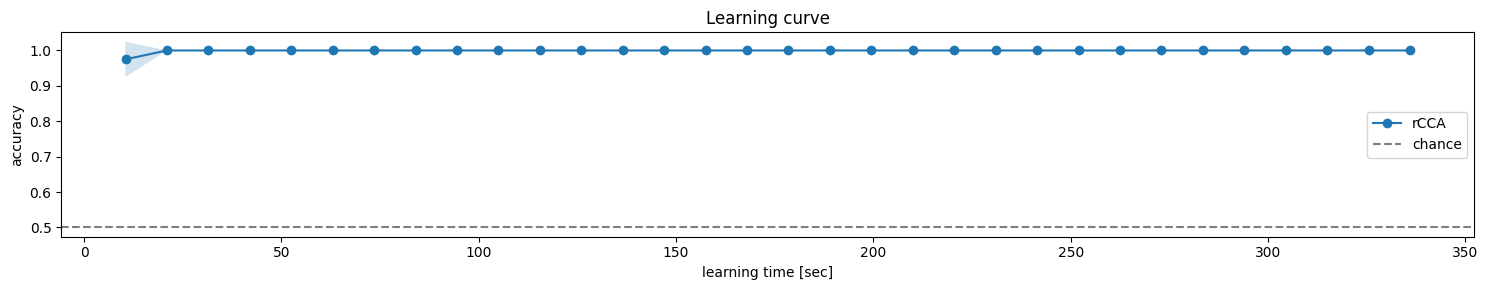

In [60]:
# Learning curve
# Chronological cross-validation
# n_folds = 3 # This will change depending on the size of the data set
folds = np.repeat(np.arange(n_folds), int(n_trials / n_folds))

print(int(n_trials / n_folds))

# Set learning curve axis
train_trials = np.arange(1, 1 + np.sum(folds != 0))
n_train_trials = train_trials.size

# Loop folds
accuracy = np.zeros((n_folds, n_train_trials))
for i_fold in range(n_folds):

    # Split data to train and test set
    X_trn, y_trn = X[folds != i_fold, :, :n_samples], y[folds != i_fold]
    X_tst, y_tst = X[folds == i_fold, :, :n_samples], y[folds == i_fold]

    # Loop train trials
    for i_trial in range(n_train_trials):

        # Train classifier
        rcca = pyntbci.classifiers.rCCA(codes=V, fs=fs, event="duration", transient_size=0.3, onset_event=True)
        rcca.fit(X_trn[:train_trials[i_trial], :, :], y_trn[:train_trials[i_trial]])

        # Apply classifier
        yh_tst = rcca.predict(X_tst)

        # Compute accuracy
        accuracy[i_fold, i_trial] = np.mean(yh_tst == y_tst)

# Plot results
plt.figure(figsize=(15, 3))
avg = accuracy.mean(axis=0)
std = accuracy.std(axis=0)
plt.plot(train_trials * trialtime, avg, linestyle='-', marker='o', label="rCCA")
plt.fill_between(train_trials * trialtime, avg + std, avg - std, alpha=0.2, label="_rCCA")
plt.axhline(1 / n_classes, color="k", linestyle="--", alpha=0.5, label="chance")
plt.xlabel("learning time [sec]")
plt.ylabel("accuracy")
plt.legend()
plt.title("Learning curve")
plt.tight_layout()

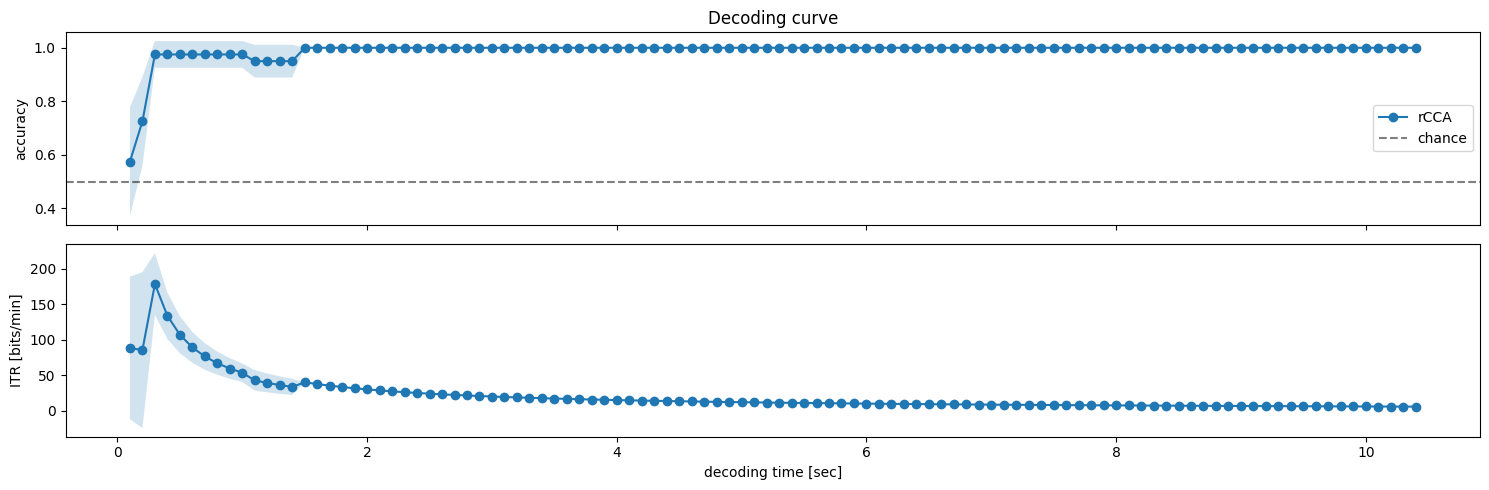

In [61]:
## Decoding Curve

# Chronological cross-validation
# n_folds = 3
folds = np.repeat(np.arange(n_folds), int(n_trials / n_folds))

# Set decoding curve axis
segmenttime = 0.1  # step size of the decoding curve in seconds
segments = np.arange(segmenttime, trialtime, segmenttime)
n_segments = segments.size

# Loop folds
accuracy = np.zeros((n_folds, n_segments))
for i_fold in range(n_folds):

    # Split data to train and test set
    X_trn, y_trn = X[folds != i_fold, :, :n_samples], y[folds != i_fold]
    X_tst, y_tst = X[folds == i_fold, :, :n_samples], y[folds == i_fold]

    # Setup classifier
    rcca = pyntbci.classifiers.rCCA(codes=V, fs=fs, event="duration", transient_size=0.3, onset_event=True)

    # Train classifier
    rcca.fit(X_trn, y_trn)

    # Loop segments
    for i_segment in range(n_segments):

        # Apply classifier
        yh_tst = rcca.predict(X_tst[:, :, :int(fs * segments[i_segment])])

        # Compute accuracy
        accuracy[i_fold, i_segment] = np.mean(yh_tst == y_tst)

# Compute ITR
time = np.tile(segments[np.newaxis, :], (n_folds, 1))
itr = pyntbci.utilities.itr(n_classes, accuracy, time + intertrialtime)

# Plot results
fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True)
avg = accuracy.mean(axis=0)
std = accuracy.std(axis=0)
ax[0].plot(segments, avg, linestyle='-', marker='o', label="rCCA")
ax[0].fill_between(segments, avg + std, avg - std, alpha=0.2, label="_rCCA")
ax[0].axhline(1 / n_classes, color="k", linestyle="--", alpha=0.5, label="chance")
avg = itr.mean(axis=0)
std = itr.std(axis=0)
ax[1].plot(segments, avg, linestyle='-', marker='o', label="rCCA")
ax[1].fill_between(segments, avg + std, avg - std, alpha=0.2, label="_rCCA")
ax[1].set_xlabel("decoding time [sec]")
ax[0].set_ylabel("accuracy")
ax[1].set_ylabel("ITR [bits/min]")
ax[0].legend()
ax[0].set_title("Decoding curve")
fig.tight_layout()
